# 制御シミュレーション

In [15]:
from math import cos, sin, pi
import numpy as np
import scipy as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib.animation as anm

import sys
sys.path.append('.')
import state_eq
import A
import B

## 倒立振子のモデル

In [16]:
class Model:
    """倒立振子のモデル"""
    M = 1
    m = 0.7
    l = 0.15
    D_x = 0.01
    D_theta = 0.01
    g = 9.80665
    
    def __init__(self,):
        pass
    
    @classmethod
    def f(cls, x, u):
        return state_eq.f(x, u, cls.m, cls.M, cls.l, cls.g, cls.D_x, cls.D_theta)
    
    @classmethod
    def A(cls, x):
        return A.f(x, cls.m, cls.M, cls.l, cls.g, cls.D_x, cls.D_theta)
    
    @classmethod
    def B(cls, x):
        return B.f(x, cls.m, cls.M, cls.l, cls.g, cls.D_x, cls.D_theta)

# 制御の例
### PID
作成中  

In [17]:
class PIDController:
    name = 'PID'
    def __init__(self, dt, Kp=150, Ki=1.5, Kd=15):
        self.dt = dt
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        
        self.integral_error = 0
    
    def input(self, x):
        u = self.Kp*(x[2, 0]) + self.Ki*(self.integral_error) + self.Kd*(x[3, 0])
        self.integral_error += x[2, 0]*self.dt
        #print(u)
        return u

### LQR

In [18]:
class LQRController:
    name = 'LQR'
    def __init__(self, Q=np.diag([10, 0, 100, 0]), R=np.array([[0.01]])):

        P = sp.linalg.solve_continuous_are(
            a = Model.A(np.zeros((4, 1))),
            b = Model.B(np.zeros((4, 1))),
            q = Q,
            r = R,
        )  # solve ricatti eq
        
        self.F = -np.linalg.inv(R) @ Model.B(np.zeros((4,1))).T @ P
        
    
    def input(self, x):
        return self.F @ x

シミュレーションを行う

In [19]:
class Simulator:
    def __init__(self, x0, TIME_SPAN, TIME_INTERVAL, controller):
        
        self.x0 = x0
        self.TIME_SPAN = TIME_SPAN
        self.TIME_INTERVAL = TIME_INTERVAL
        self.controller = controller
    
    def dX(self, t, x):
        x = x.reshape(-1, 1)
        x_dot = Model.f(x, self.controller.input(x))
        return np.ravel(x_dot)
    
    def run_simulation(self,):
        self.sol = integrate.solve_ivp(
            fun = self.dX,
            t_span = (0, self.TIME_SPAN),
            y0 = self.x0,
            t_eval = np.arange(0, self.TIME_SPAN, self.TIME_INTERVAL),
            atol=1e-6
        )
    
    def plot(self,):
        fig, ax = plt.subplots(2, 2, figsize=(8, 8))
        ax[0,0].plot(self.sol.t, self.sol.y[0], label="x")
        ax[0,1].plot(self.sol.t, self.sol.y[1], label="v")
        ax[1,0].plot(self.sol.t, self.sol.y[2], label="theta")
        ax[1,1].plot(self.sol.t, self.sol.y[3], label="omega")
        for i in range(2):
            for j in range(2):
                ax[i, j].legend()
                ax[i, j].grid(); ax[i, j].set_title(self.controller.name)
        plt.show()
    
    def make_animation(self,):
        x_max = max(self.sol.y[0])
        x_min = min(self.sol.y[0])
        time_template = 'time = %s [sec]'
        
        def update(i):
            ax.cla()
            
            pen_x = [self.sol.y[0][i], self.sol.y[0][i]+Model.l*2*cos(pi/2-self.sol.y[2][i])]
            pen_y = [0, Model.l*2*sin(pi/2-self.sol.y[2][i])]
            
            ax.plot(pen_x, pen_y, label="pen")
            
            ax.set_xlim(x_min-Model.l*2, x_max+Model.l*2)
            ax.set_ylim(-Model.l*2.2, Model.l*2.2)
            
            ax.text(0.05, -0.15, time_template % format(self.sol.t[i], '.1f'), size = 10)
            
            ax.legend()
            ax.grid()
            ax.set_aspect('equal')
            ax.set_title(self.controller.name)
        
        
        fig, ax = plt.subplots()
        ani = anm.FuncAnimation(
            fig = fig,
            func = update,
            frames = range(0, len(self.sol.t), 20),
        )
        ani.save(self.controller.name+".gif", writer="pillow")
        plt.show()
        return ani

In [20]:
x0 = np.array([0, 0, pi/6, 0])
TIME_SPAN = 5
TIME_INTERVAL = 0.01

controller = LQRController()

sim = Simulator(x0, TIME_SPAN, TIME_INTERVAL, controller)
sim.run_simulation()
sim.sol.message

c:\Users\Yoshi\source_control_study\ans_2022\excercise\Python_src\state_eq.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array([[x[1, 0]], [3*D_theta*numpy.cos(x[2, 0])*x[3, 0]/(4*M*l + 3*l*m*numpy.sin(x[2, 0])**2 + l*m) - 4*D_x*l*x[1, 0]/(4*M*l + 3*l*m*numpy.sin(x[2, 0])**2 + l*m) - 3*g*l*m*numpy.sin(2*x[2, 0])/(8*M*l + 6*l*m*numpy.sin(x[2, 0])**2 + 2*l*m) + 4*l**2*m*numpy.sin(x[2, 0])*x[3, 0]**2/(4*M*l + 3*l*m*numpy.sin(x[2, 0])**2 + l*m) + 4*l*u/(4*M*l + 3*l*m*numpy.sin(x[2, 0])**2 + l*m)], [x[3, 0]], [-3*D_theta*M*x[3, 0]/(4*M*l**2*m + 3*l**2*m**2*numpy.sin(x[2, 0])**2 + l**2*m**2) - 3*D_theta*m*x[3, 0]/(4*M*l**2*m + 3*l**2*m**2*numpy.sin(x[2, 0])**2 + l**2*m**2) + 3*D_x*l*m*numpy.cos(x[2, 0])*x[1, 0]/(4*M*l**2*m + 3*l**2*m**2*numpy.sin(x[2, 0])

'The solver successfully reached the end of the integration interval.'

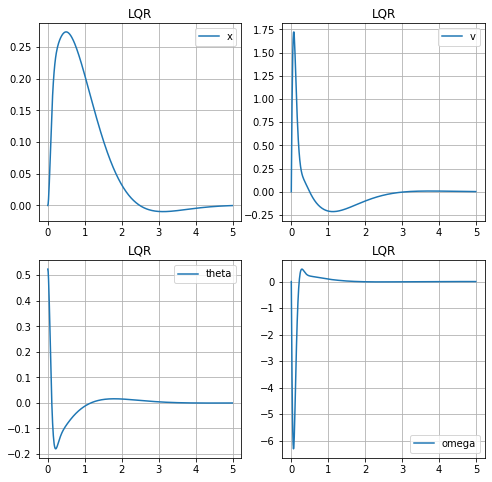

In [21]:
sim.plot()

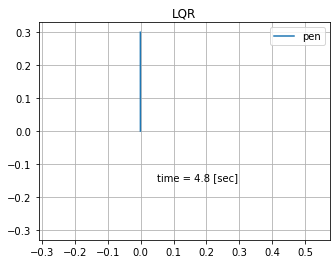

In [22]:
sim.make_animation()

![hoge](LQR.gif)

In [32]:
x0 = np.array([0, 0, pi/6, 0])
TIME_SPAN = 5
TIME_INTERVAL = 0.01

controller = PIDController(TIME_INTERVAL, Ki=11)


sim2 = Simulator(x0, TIME_SPAN, TIME_INTERVAL, controller)
sim2.run_simulation()
sim2.sol.message

'The solver successfully reached the end of the integration interval.'

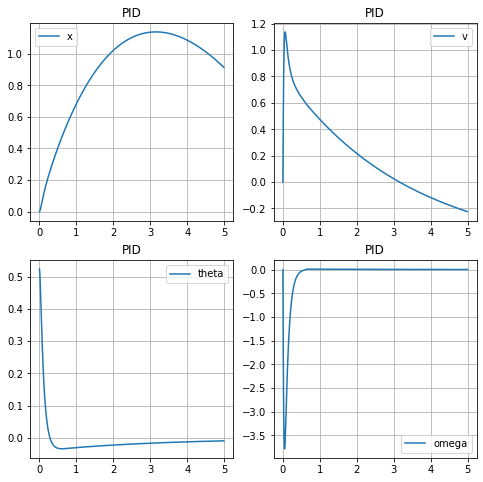

In [33]:
sim2.plot()

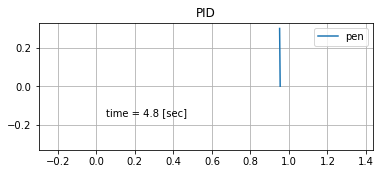

In [34]:
sim2.make_animation()

![pid](PID.gif)